In [1]:
from synthetic.predictor import predict_trajectory
import numpy as np
import matplotlib.pyplot as plt
from draw_util import draw_util
from pycamera import CameraParam
import csv
from pathlib import Path
from hydra import compose, initialize
from pathlib import Path
from matplotlib import pyplot as plt
import os
try:
    initialize(version_base=None, config_path="../../conf")
except:
    print("Hydra already initialized")
cfg=compose(config_name="config.yaml")

ROOT = Path("../../") # jupyter only
os.chdir(ROOT)
print(os.getcwd())

%matplotlib widget

# toggle this to enable/disable test
TEST_SINGLE_CASE = False # Done
VIEW_GENERATED_TRAJECTORY = True
VIEW_GENERATED_CAMERA_DATA = True
VIEW_MODEL_VALIDATION = True

/home/qingyu/lfg


In [3]:
# load camera parameters
def get_camera_param_dict(cfg):
    camera_param_dict = {camera_id: CameraParam.from_yaml(Path(cfg.camera.folder) / f'{camera_id}_calibration.yaml') for camera_id in cfg.camera.cam_ids}
    return camera_param_dict
# camera_param_dict = {camera_id: CameraParam.from_yaml(Path(CONFIG.camera.folder) / f'{camera_id}_calibration.yaml') for camera_id in CONFIG.camera.cam_ids}
# camera_ids = CONFIG.camera.cam_ids

def test_single_case(cfg):
    camera_param_dict = get_camera_param_dict(cfg)
    p0 = np.array([0.5, -2.4, 0.2])
    v0 = np.array([0.0, 5.0, 1.5])
    w0 = np.array([0.0, 30.0, 0.0]) * np.pi * 2
    tspan = np.linspace(0, 1.0, 100)
    traj = predict_trajectory(p0, v0, w0, tspan)

    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(projection='3d')
    ax.scatter(traj[:,0],traj[:,1],traj[:,2],s=3, label='sim')
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.set_zlabel('Z (m)')
    ax.legend()
    for cm in camera_param_dict.values():
        cm.draw(ax,scale=0.20)
    draw_util.set_axes_equal(ax)
    draw_util.set_axes_pane_white(ax)
    draw_util.draw_pinpong_table_outline(ax)

if TEST_SINGLE_CASE:
    test_single_case(cfg)

TypeError: unsupported operand type(s) for /: 'str' and 'str'

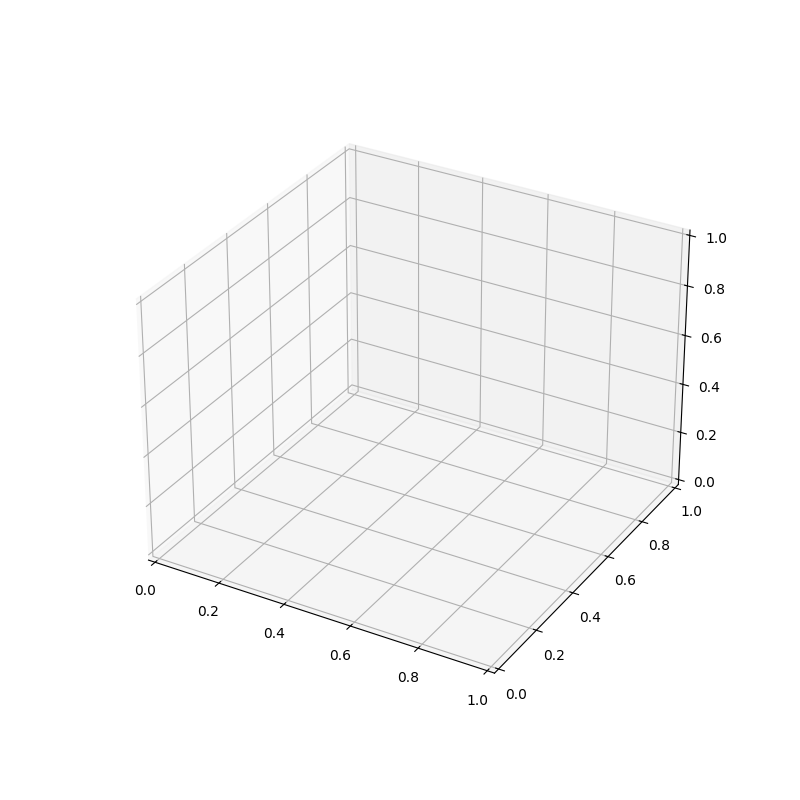

In [4]:
def load_synthetic_data(file_path):
    with open(file_path, mode='r') as f:
        reader = csv.reader(f)
        data = [row for row in reader]
    data = np.array(data, dtype=float)
    return data
def view_generated_trajectory(cfg):
    camera_param_dict = get_camera_param_dict(cfg)
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(projection='3d')

    data = load_synthetic_data( cfg.dataset.folder / cfg.dataset.trajectory_data)
    traj_idx_list = np.arange(int(data[-1,0]))
    traj_idx_list = np.random.choice(traj_idx_list, 200, replace=True)
    for traj_idx in traj_idx_list[:-1:10]:
        traj = data[data[:,0] == traj_idx, 2:]
        ax.scatter(traj[:,0],traj[:,1],traj[:,2],s=3, label='sim')
        ax.set_xlabel('X (m)')
        ax.set_ylabel('Y (m)')
        ax.set_zlabel('Z (m)')
        draw_util.set_axes_equal(ax)
        draw_util.set_axes_pane_white(ax)
        draw_util.draw_pinpong_table_outline(ax)
    for cm in camera_param_dict.values():
        cm.draw(ax,scale=0.20)
if VIEW_GENERATED_TRAJECTORY:
    view_generated_trajectory(cfg)

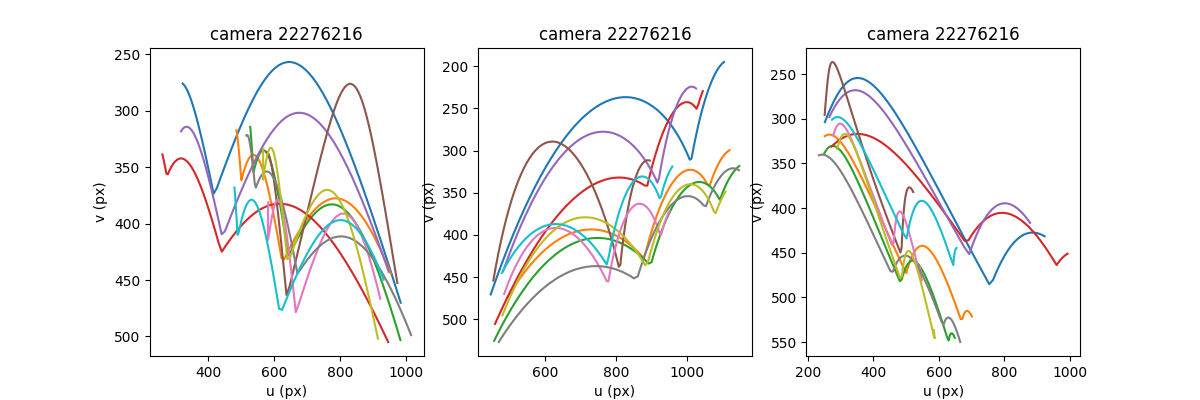

In [8]:



def view_generated_camera_data(cfg):
    camera_ids = cfg.camera.cam_ids 
    fig = plt.figure(figsize=(12,4))
    ax_dict = {cam_id: fig.add_subplot(1,3,i+1) for i, cam_id in enumerate(camera_ids)}

    data = load_synthetic_data(Path(cfg.dataset.folder) / cfg.dataset.camera_data)
    traj_idx_list = np.arange(int(data[-1,0]))
    traj_idx_list = np.random.choice(traj_idx_list, 10, replace=True)

    for traj_idx in traj_idx_list:
        for cam_id in camera_ids:
            ax = ax_dict[cam_id]
            uv = data[(data[:,0].astype(int) == traj_idx) & (data[:,3].astype(int) == int(cam_id)), 4:6]
            ax.plot(uv[:,0],uv[:,1],linestyle='-')
    for ax in ax_dict.values():
        ax.set_xlabel('u (px)')
        ax.set_ylabel('v (px)')
        ax.set_title(f'camera {cam_id}')
        ax.invert_yaxis()

if VIEW_GENERATED_CAMERA_DATA:
    view_generated_camera_data(cfg)

In [12]:
def get_max_run_index(p: Path):
    runs = list(p.glob("run*"))
    if len(runs) == 0:
        LookupError(f"No runs found at {p}")
    run_indices = [int(str(run).split("run")[-1]) for run in runs]
    return max(run_indices)

def view_model_prediction(cfg):
    from train import  get_camera_param_dict, get_model, get_data_loaders, get_summary_writer
    import torch
    
    camera_param_dict = get_camera_param_dict(cfg)
    model, autoregr = get_model(cfg)
    model_path = Path(cfg.model.logdir) / cfg.dataset.name
    run_idx = get_max_run_index(model_path)
    
    model.load_state_dict(torch.load(f"{model_path}/run{run_idx:02d}/model_{cfg.model.model_name}.pth"))
    autoregr(model, data, camera_param_dict, fraction_est)
    

view_model_prediction(cfg)